In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import glob

# Cargando las imágenes y las labels

In [60]:
def get_labels(g_path, paths1, paths2):
  all_files = []
  all_img = []
  labels = []

  for path1 in paths1:
    for path2 in paths2:
      files = ([f for f in glob.glob(g_path + path1 + path2 + "**/*.jpg", 
                                    recursive=True)] 
              + [f for f in glob.glob(g_path  + path1 + path2 + "**/*.jpeg", 
                                    recursive=True)])
      all_files += files
      images = []
      for f in files:
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        images.append(img)

      supp_ind_label1 = np.where(path1 == np.array(paths1))[0]
      if len(supp_ind_label1)==1:
        ind_label = [float(supp_ind_label1[0])]
      else:
        print('Error path1 mal puesto')

      supp_ind_label2 = np.where(path2 == np.array(paths2))[0]
      if len(supp_ind_label2)==1:
        ind_label.append(float(supp_ind_label2[0]))
      else:
        print('Error path2 mal puesto')
      labels += [ind_label]*len(files)
      all_img += images
  return all_img, labels, all_files

In [61]:
g_path = '/content/drive/MyDrive/Fotos Proyecto/'
paths1 = ['HORIZONTAL/', 'VERTICAL/'] # HORIZONATALES=0, VERTICALES=1
paths2 = ['B&N/', 'COLOR/'] # BLANCO Y NEGRO=0, COLOR=1
g_path2 = '/content/drive/MyDrive/Fotos Proyecto/PRUEBA/'

all_img, labels, all_files = get_labels(g_path, paths1, paths2)

In [62]:
for image in all_img:
  plt.imshow(image)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Bots

## Horizontal/Vertical

In [ ]:
def get_hv_label(x):
shape = x.shape[:-1]
if shape[0] > shape[1]:
  return 0
elif shape[1] > shape[0]:
  return 1
else:
  return 2

## B&W/Color

In [ ]:
def get_95perc_gray_diff(x):
  new_x = x.reshape(x.shape[0]*x.shape[1], 3)
  max_value = np.max(new_x, axis=1)
  min_value = np.min(new_x, axis=1)
  return np.percentile((max_value - min_value), 95)

In [ ]:
bwc_labels = list(map(get_95perc_gray_diff, all_img))
pd.DataFrame(bwc_labels).value_counts()

0.0      11
5.0       3
93.0      2
45.0      2
73.0      2
62.0      1
15.0      1
25.0      1
39.0      1
40.0      1
42.0      1
46.0      1
48.0      1
166.0     1
70.0      1
161.0     1
74.0      1
81.0      1
99.0      1
105.0     1
121.0     1
124.0     1
128.0     1
131.0     1
72.0      1
dtype: int64

In [294]:
def is_grey(x):
  new_x = x.reshape(x.shape[0]*x.shape[1], 3)
  max_value = np.max(new_x, axis=1)
  min_value = np.min(new_x, axis=1)
  supp = (max_value - min_value) < 20
  gray_porc = supp.sum()/new_x.shape[0]
  if gray_porc < 0.97:
    label = 1.
  else:
    label = 0.
  return label

In [338]:
def is_sepia(x):
  supp_sepia_mask = x.sum(axis=2) + 0.00001

  maskRchs = np.logical_and((x[:,:,0]/supp_sepia_mask) > 0.35, (x[:,:,0]/supp_sepia_mask) < 0.60)
  maskGchs = np.logical_and((x[:,:,1]/supp_sepia_mask) > 0.25, (x[:,:,1]/supp_sepia_mask) < 0.55)
  maskBchs = (x[:,:,2]/supp_sepia_mask) < 0.3
  sepiaMask = np.logical_and(maskRchs, maskGchs, maskBchs)

  #maskRchw = x[:,:,0] > 248
  #maskGchw = x[:,:,1] > 248
  #maskBchw = x[:,:,2] > 248
  #whiteMask = np.logical_and(maskRchw, maskGchw, maskBchw)

  # maskRchb = x[:,:,0] < 10
  # maskGchb = x[:,:,1] < 10
  # maskBchb = x[:,:,2] < 10
  # blackMask = np.logical_and(maskRchb, maskGchb, maskBchb)

  #mask = np.logical_or(sepiaMask, whiteMask, blackMask)
  mask = sepiaMask
  sepia_perc = mask.sum()/(x.shape[0] * x.shape[1])
  if sepia_perc < 0.9:
    label = 1.
  else:
    label = 0.
  return label

In [339]:
def get_bwc_label(x):
  label = is_grey(x)
  if label == 0.:
    return label
  else:
    return is_sepia(x)

In [340]:
bwc_labels = list(map(is_sepia, all_img))
pd.DataFrame(bwc_labels).value_counts()

1.0    30
0.0    10
dtype: int64

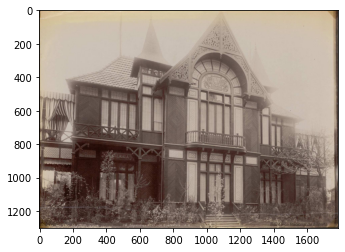

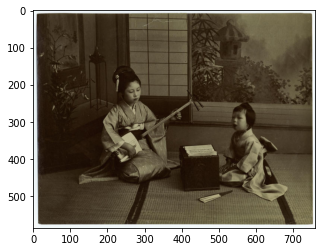

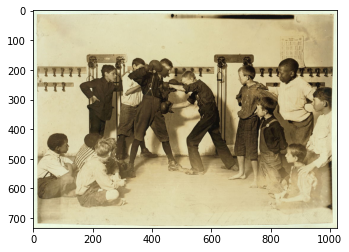

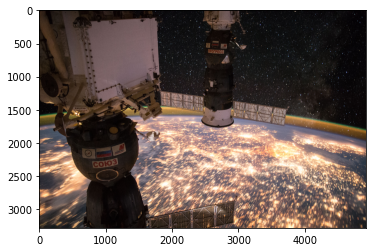

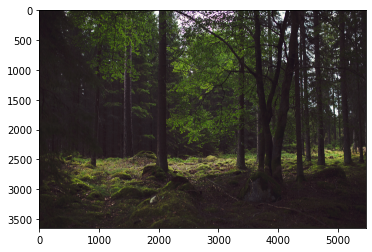

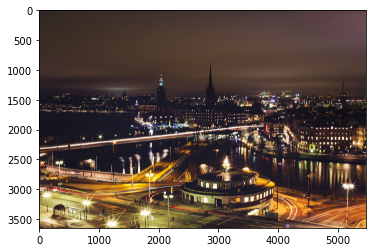

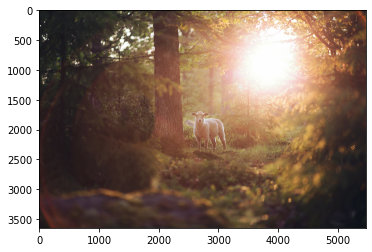

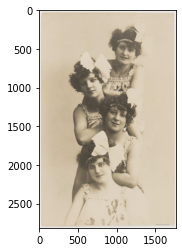

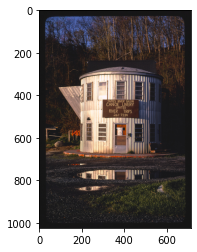

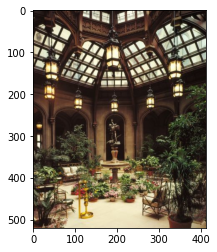

In [341]:
index = np.where(np.array(bwc_labels) == 0.0)[0]

for ind in index:
  image = all_img[ind]
  plt.imshow(image)
  plt.show()

## Moving files from labels

In [ ]:
def moving_files(g_path, path1, path2, hv_labels, bwc_labels, all_files):
  g_path = '/content/drive/MyDrive/IMAGENES PARA IA/PRUEBA/'
  paths1 = ['HORIZONTALES/', 'VERTICALES/'] # HORIZONATALES=0, VERTICALES=1
  paths2 = ['B&N/', 'COLOR/'] # BLANCO Y NEGRO=0, COLOR=1

  for i in range(len(all_files)):
    current_file = all_files[i]
    foto_name = current_file.split('/')[-1]
    new_file = g_path + paths1[hv_labels[i]] + paths2[bwc_labels[i]] + foto_name
    # shutil.move(current_file, new_file) Lo eficiente sería moverlo con esto pero ahora mismo no queremos perderlas del sitio original
    shutil.copy(current_file, new_file)

## Bot constructor

In [321]:
class bot_fotos_hv_bnc:
  def __init__(self, g_path, g_path2, paths1, paths2):
    self.g_path = g_path
    self.paths1 = paths1
    self.paths2 = paths2
    self.g_path2 = g_path2
  def get_img(self):
    all_files = []
    all_img = []
    files = ([f for f in glob.glob(self.g_path + "**/*.jpg", recursive=True)] 
                + [f for f in glob.glob(self.g_path + "**/*.jpeg", recursive=True)])

    all_files += files
    images = []

    for f in files:
      img = cv2.imread(f)
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      images.append(img)
    all_img += images

    self.all_img = all_img
    self.all_files = all_files

  def get_hv_label(self, x):
    shape = x.shape[:-1]
    if shape[1] > shape[0]:
      return 0.
    elif shape[0] > shape[1]:
      return 1.
  def is_grey(self, x):
    new_x = x.reshape(x.shape[0]*x.shape[1], 3)
    max_value = np.max(new_x, axis=1)
    min_value = np.min(new_x, axis=1)
    supp = (max_value - min_value) < 20
    gray_porc = supp.sum()/new_x.shape[0]
    if gray_porc < 0.97:
      label = 1.
    else:
      label = 0.
    return label
  def is_sepia(self, x):
    supp_sepia_mask = x.sum(axis=2) + 0.00001

    maskRchs = np.logical_and((x[:,:,0]/supp_sepia_mask) > 0.35, (x[:,:,0]/supp_sepia_mask) < 0.60)
    maskGchs = np.logical_and((x[:,:,1]/supp_sepia_mask) > 0.25, (x[:,:,1]/supp_sepia_mask) < 0.55)
    maskBchs = (x[:,:,2]/supp_sepia_mask) < 0.3
    sepiaMask = np.logical_and(maskRchs, maskGchs, maskBchs)

    mask = sepiaMask
    sepia_perc = mask.sum()/(x.shape[0] * x.shape[1])
    if sepia_perc < 0.9:
      label = 1.
    else:
      label = 0.
    return label
  def get_bwc_label(self, x):

    label = is_grey(x)
    if label == 0.:
      return label
    else:
      return is_sepia(x)
  def get_all_labels(self):
    self.hv_labels = list(map(self.get_hv_label, self.all_img))
    self.bwc_labels = list(map(self.get_bwc_label, self.all_img))

  def moving_files(self, g_path2):
    for i in range(len(self.all_files)):
      current_file = self.all_files[i]
      foto_name = current_file.split('/')[-1]
      new_file = (self.g_path2 + self.paths1[int(self.hv_labels[i])] + 
                  self.paths2[int(self.bwc_labels[i])] + foto_name)
      try:
        shutil.copy(current_file, new_file)
      except IOError as io_err:
        os.makedirs(os.path.dirname(new_file))
        shutil.copy(current_file, new_file)
        
  def running(self):
    self.get_img()
    self.get_all_labels()
    self.moving_files(self.g_path2)
    print("Se han movido los archivos")

  def plot_results(self):
    for ind in range(len(self.all_files)):
      f = self.all_files[ind]
      img = cv2.imread(f)
      image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      hv = self.paths1[int(self.hv_labels[ind])][:-1]
      bwc = self.paths2[int(self.bwc_labels[ind])][:-1]
      print(f'{hv}, {bwc}')
      plt.imshow(image)
      plt.show()

## Running the bot

In [314]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shutil
import glob
import os

In [315]:
g_path = '/content/drive/MyDrive/Fotos Proyecto/TODAS/'
paths1 = ['HORIZONTAL/', 'VERTICAL/'] # HORIZONATALES=0, VERTICALES=1
paths2 = ['B&N/', 'COLOR/'] # BLANCO Y NEGRO=0, COLOR=1
g_path2 = '/content/drive/MyDrive/Fotos Proyecto/PRUEBA/'

bot = bot_fotos_hv_bnc(g_path, g_path2, paths1, paths2)
bot.running()

Se han movido los archivos


In [320]:
f = bot.all_files[0]
img = cv2.imread(f)
image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
image.shape[0]

2413

In [316]:
bot.plot_results()

Output hidden; open in https://colab.research.google.com to view.

# Neural Network to predict horizontal/vertical images

In [ ]:
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf

In [ ]:
x_train = []

for image in all_img:
  x_train.append(list(image.shape[:-1]))

x = np.array(x_train)
y = labels2.iloc[:,1:]
y = np.concatenate([y, 1-y], axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, 
                                                    random_state=42, stratify=y)

In [ ]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(10, input_shape=(2,), activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 22        
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
1/1 [==============================] - 0s 465ms/step - loss: 153.6899 - val_loss: 122.2320
Epoch 2/100
1/1 [==============================] - 0s 44ms/step - loss: 149.1761 - val_loss: 118.9056
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 144.6759 - val_loss: 115.5892
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 140.1896 - val_loss: 112.2829
Epoch 5/100
1/1 [==============================] - 0s 48ms/step - loss: 135.7200 - val_loss: 108.9889
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 131.3641 - val_loss: 105.7205
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 127.0577 - val_loss: 102.4734
Epoch 8/100
1/1 [==============================] - 0s 55ms/step - loss: 122.7696 - val_loss: 99.2446
Epoch 9/100
1/1 [==============================] - 0s 45ms/step - loss: 118.4988 - val_loss: 96.0321
Epoch 10/100
1/1 [==============================] - 0s 50ms/step - loss: 114.2447 -

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(model.predict(x_train), axis=1), y_train[:,0])

0.46875